In [1]:
#setup plotting and special functions
import sys
sys.path.append('os.getcwd()')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import special, optimize, integrate
from numpy import random
from numpy import exp as exp
def gamma_porp(a,b):
    from scipy import special
    return special.gamma(a)-special.gamma(a)*special.gammainc(a,b)
import geopandas as gp
import urllib2
%matplotlib inline
import scipy
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
def g(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

def KirchnerG(q,a,b,c):
    return np.exp(a*np.log(q)**2 + b*np.log(q) + c)

def KirchnerBinning(df, loud=False):
    df = df.sort_values(by='q',ascending=False)
    
    logQ = np.array(np.log(df.q))
    
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*.01
  
    binBoundaries = [0]
    for i in range(1,len(df)):    
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize: 
            if loud: print('Bin too small')
            continue
            
        curr = df.Dunsmooth[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2: 
            if loud: print('Bin too heterogeneous')
            continue    
        
        binBoundaries.append(i)
    
    return binBoundaries

def getFlow(site):
    '''
        Input: USGS gage number
        
        Output: pandas data frame of volumetric streamflow (over period of record at the gage) indexed by datetime
    '''
    
    try: 
        f = open('flow_data/'+ site + '.txt','r')
    except: 
        print('downloading data')
        site = str(site)

        url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date=1950-01-01&end_date=2017-05-01'
        response = urllib2.urlopen(url)
        content = response.read()

        f = open('flow_data/'+ site+'.txt','w')
        f.write(content)
        f.close()

    count = 0
    for line in open('flow_data/'+ site+'.txt','r').readlines():
        if line[0] == '#': 
            count += 1
        else:
            break

    df = pd.read_csv('flow_data/'+ site+'.txt', header=count, delimiter='\t')

    q_col = next(col for col in df.columns if col.endswith('00060_00003'))
    
    df.rename(columns={q_col: 'q', 'datetime':'date'}, inplace=True)    
    df = df.iloc[1:,:]
    df = df.dropna()

    df.date = pd.to_datetime(df.date)
    df.q = pd.to_numeric(df.q)
    
    df.index = pd.to_datetime(df.date)
    
    return df

def _finditem(obj, key):
    if key in obj: return obj[key]
    for k, v in obj.items():
        if isinstance(v,dict):
            return _finditem(v, key)

[ 1.48496192  0.4005573   1.59727612]
[ 0.32234093  0.21417611  1.42217034]
[ 4.59139635  0.24332408  1.5474713 ]
[ 2.1858925   0.16169283  1.90295395]
[ 2.70663987  0.28004043  1.28670156]
[ 4.32500882  0.15083934  1.28553279]
[ 8.43554772  0.27923158  1.39103612]
[ 2.6061727   0.25719197  1.0246141 ]
[ 6.03330257  0.18301528  1.45050726]
[ 6.38387575  0.35777477  0.99342299]
[ 1.51097841  0.20870626  2.17122417]
[ 0.6703865   0.8022719   1.87851598]
[ 2.64071559  0.14637277  1.71631011]
[ 3.90836854  0.14210395  1.6939726 ]
[ 5.8804193   0.22002748  1.48380255]
[ 0.92967728  0.31386567  4.06309432]
[  0.26167273  18.10630704   2.54976429]
[ 0.54160584  0.38365528  2.13354041]
[ 1.05318969  0.20073628  0.98728952]
[ 6.25242961  0.25014119  1.77035558]
[ 2.27716876  0.23949074  1.1370045 ]
[ 0.83680506  0.23167573  1.80994339]
[ 2.45242227  0.18669921  2.03178936]
[ 5.42590457  0.23073293  1.00862571]
[ 3.80635532  0.12088418  1.904065  ]
[ 2.36062068  0.12139248  1.55878918]
[ 21.3548

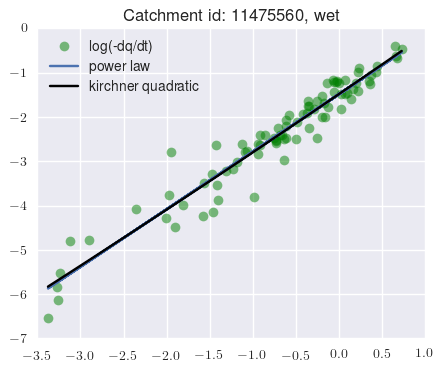

In [9]:
# Setup sitelist (by USGS gage id) and seasons for extraction
site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')
sitelist = ['11475560']
seasons = ['wet']
start_stop = [ (pd.to_datetime('1950-1-1'), pd.to_datetime('2017-1-1')) ]
fittingType = 'KirchnerBins'
Kdict = {}
datedict = {}
A = {}
B = {}
P = {}
bvec = []

# Recession extraction options
option=1
start = 1
selectivity = 200
window = 3
minLen = 5

for ind, site in enumerate(sitelist):
    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])
    d = getFlow(site)
    d.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    d.q = d.q/(2.58998811e10*area)*2.44657555e9 
    d = d.loc[start_stop[ind][0]:start_stop[ind][1]]
    
    

    # FOR streamflow.txt in fh, load data, get median k by extracting individual recessions
    # and fitting q(t) = q0*exp(-kt)

    def func(t, q0, k):
        return q0*np.exp(-k*t)
    Ks = []
    dateList = []
    if seasons[ind]=='winter':
        tw = len(pd.date_range('12-2015', '3-2016'))
        d = d.q.loc[(d.index.month>=12)|(d.index.month<=2)].ffill()
    elif seasons[ind]=='spring': 
        tw = len(pd.date_range('3-2016', '6-2016'))
        d = d.q.loc[(d.index.month>=3)&(d.index.month<=5)].ffill()
    elif seasons[ind]=='summer':
        tw = len(pd.date_range('6-2016', '9-2016'))
        d = d.q.loc[(d.index.month>=6)&(d.index.month<=8)].ffill()
    elif seasons[ind]=='fall':
        tw = len(pd.date_range('9-2016', '12-2016'))
        d = d.q.loc[(d.index.month>=9)&(d.index.month<=11)].ffill()
    elif seasons[ind]=='wet':
        tw = len(pd.date_range('11-2016', '4-2017'))
        d = d.q.loc[(d.index.month>=11)|(d.index.month<=4)].ffill()  

    # hang on to dates for later use
    dates = d.index
    d = pd.DataFrame({'q':d.tolist()})
    selector = (d.q.max()-d.q.min())/selectivity
    [maxtab, mintab]=peakdet(d.q, selector)
    d['peaks']=-1
    d.ix[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]
    d['smooth']= d.q.rolling(window).mean(); d['smooth'][0:2] = d.q[0:2]
    d['Dunsmooth']= d.q.diff().shift(-1)
    d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
    d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
    d = d[:-2]

    #boolean vector for recession periods 
    if option==0:
        d['choose']=d['Dunsmooth']<=0
    else:
        d['choose']=(d['Dunsmooth']<0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))

    datesMax = d.ix[d['peaks']>0].index

    for i in np.arange(len(datesMax)-1):
        recStart = datesMax[i]; peak1 = datesMax[i]+start; peak2 = datesMax[i+1]
        recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
        if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
            continue
        t = np.arange(len(d.q[recStart:recEnd]))
        q0_data = d.q.loc[recStart]
        def func(t, q0, a, b):
            return ((-1+b)*(q0**(1-b)/(b-1)+a*t))**(1/(1-b))
        try:
            popt, cov = curve_fit(func,t,d.q[recStart:(recEnd)],[q0_data, .1, 1.5])
            print popt
            if (popt[2]>0)&(popt[2]<10):
                bvec.append(popt[2])


        except RuntimeError:
            print('Error encountered in fitting')
            continue

        Ks.append(popt[1])
        dateList.append(dates[i])
        
    # Perform Kirchner fitting
    if fittingType == 'KirchnerBins':
        recessions = d.loc[d.choose]
        binBoundaries = KirchnerBinning(d.loc[d.choose])
        qs = [np.mean(recessions.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
        dqs =   np.array([np.mean(recessions.Dunsmooth[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
        sigmas = np.array([np.std(recessions.Dunsmooth[binBoundaries[i]:binBoundaries[i+1]])/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)])
        sigmas = np.ones(np.shape(sigmas))
        p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2, w=1/(sigmas+1e-12))
        p_powerlaw = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=1, w=1/(sigmas+1e-12))
        bcurr = p_powerlaw[0]
        acurr = np.exp(p_powerlaw[1])
        p[1] = p[1]-1
        
        plt.figure(figsize=(5,4))
        plt.plot(np.log(qs), np.log(-dqs), c='g', alpha=0.5, lw=0, marker='o', label='log(-dq/dt)')
        plt.plot(np.log(qs), p_powerlaw[1] + p_powerlaw[0]*np.log(qs), label='power law')
        plt.plot(np.sort(np.log(qs)), p[2] + (p[1]+1)*np.sort(np.log(qs)) + p[0]*np.sort(np.log(qs))**2, label='kirchner quadratic', c='k')
        plt.legend(loc='best')
        titlestr = 'Catchment id: %s, %s'%(site, seasons[ind])
        plt.title('%s'%(titlestr))

    elif fittingType == 'KirchnerNonlinear': 
        ## use the linear coefficients as the init cond for the nonlinear solver
        p = np.polyfit(np.log(recessions.q),np.log(-recessions.dq/recessions.q),2)        
        p, cov = curve_fit(lambda x, a, b, c: KirchnerG(x,a,b,c), recessions.q, -recessions.dq/recessions.q, p0=p) 
    else:
        p = np.polyfit(np.log(recessions.q),np.log(-recessions.dq/recessions.q),2)

#     A[(site, seasons[ind])] = acurr
#     B[(site, seasons[ind])] = bcurr
#     P[(site, seasons[ind])] = p
#     Kdict[(site, seasons[ind])] = Ks
#     datedict[(site, seasons[ind])] = dateList

1.6511039425832748

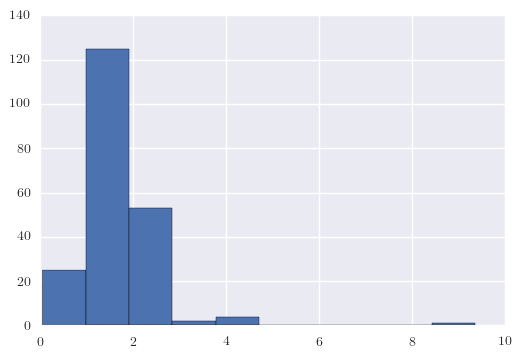

In [11]:
plt.hist(bvec)
np.mean(bvec)

In [4]:
for key in Kdict.keys():
    print('For site %s, %s: mean k is %.2f from %s recessions'%(key[0], key[1], np.mean(Kdict[key]), len(Kdict[key])))
    print('\t Kirchner binned: power law scale a = %.2f, power law exponent b = %.2f'%(A[key], B[key]))

For site 11475560, wet: mean k is 0.25 from 218 recessions
	 Kirchner binned: power law scale a = 0.23, power law exponent b = 1.30


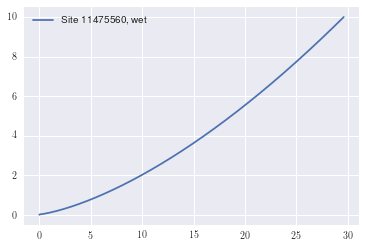

In [5]:

for key in P.keys():
    p = P[key]
    q = np.linspace(.01,10,1000)
    a,b,c = p[0], p[1], p[2]
    def KirchnerG(q,a,b,c):
        return np.exp(a*np.log(q)**2 + b*np.log(q) + c)
    g = KirchnerG(q,a,b,c)

    s = []

    for i in range(1,len(q)):
        s.append(np.trapz(1/g[:i], q[:i]))
    s = [0] + s
    plt.plot(s,q, label='Site %s, %s'%(key[0], key[1]))
    
plt.legend(loc='best')